**Import Data**

In [ ]:
import numpy as np
import pandas as pd

**Get The Data**

In [ ]:
from google.colab import files
uploaded = files.upload()
iris_data = pd.read_csv("iris.csv")
iris_data.head()

Saving iris.csv to iris.csv


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


**Node Class**

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor '''

        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left # access left child/node
        self.right = right #access right child/node
        self.info_gain = info_gain

        # for leaf node
        self.value = value #majority class of the node

**Tree Class**

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=3, max_depth=3):
        ''' constructor '''

        # initialize the root of the tree
        self.root = None

        # stopping criteria
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''

        X, Y = dataset[:,:-1], dataset[:,-1] #taking all rows and columns up to the last one (X for training - features), taking the last column(Y for target)
        num_samples, num_features = np.shape(X)

        # compute decision node
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''

        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # loop over all the features
        for feature_index in range(num_features): #explore through every possible values of a feature in the dataset
            feature_values = dataset[:, feature_index] #gets all values of the current feature
            possible_thresholds = np.unique(feature_values) #uses unique values of the current feature for possible thresholds
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get the current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold) #to get the current left (less than or equal to) and right (vice versa) child based on the current feature index and threshold
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1] #extracting the target value "y"
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy '''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''

        Y = list(Y)
        return max(Y, key=Y.count) #value = majority class value

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''

        if not tree:
            tree = self.root #set as root node if no tree is specified

        if tree.value is not None:
            print(tree.value) #print the current value if its leaf node

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        ''' function to train the tree '''

        dataset = np.concatenate((X, Y), axis=1) #used X and Y to create the dataset, combining the features with the target variable along the columns
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict new dataset ''' # using new feature, passing the root node as parameter for the prediction function

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        if tree.value!=None: return tree.value   #if a leaf node, return its value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:       #recursively building the left and right node until a leaf node is reached
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


**Train the Test-Split**

In [ ]:
X = iris_data.iloc[:, :-1].values
Y = iris_data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

**Fit The Model**

In [ ]:
classifier = DecisionTreeClassifier(min_samples_split=11, max_depth=4)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= 49.0 ? 0.33741385372714494
 left:setosa
 right:X_0 <= 100.0 ? 0.4999198846338727
  left:versicolor
  right:virginica


**Test The Model(Results)**

In [ ]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
print("Accuracy Score =", accuracy_score(Y_test, Y_pred))

Accuracy Score = 0.9666666666666667


In [ ]:
print("Classification Report - \n\n", classification_report(Y_test, Y_pred))

Classification Report - 

               precision    recall  f1-score   support

      setosa       1.00      0.89      0.94         9
  versicolor       0.92      1.00      0.96        11
   virginica       1.00      1.00      1.00        10

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



Text(0.5, 63.222222222222186, 'Predicted label')

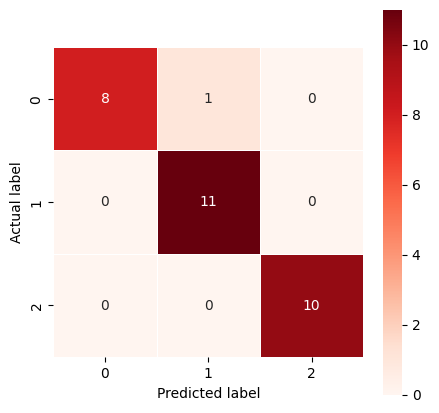

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# for encoding
cm = confusion_matrix(Y_test, Y_pred)
cm
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')